# Insurance Claims Modeling with spark-bestfit

This notebook demonstrates **actuarial modeling** of insurance claims using
statistical distribution fitting.

## What You'll Learn

1. **Model claim frequency** with discrete distributions (Poisson, Negative Binomial)
2. **Model claim severity** with heavy-tailed distributions (Pareto, Lognormal)
3. **Handle policy limits** with bounded distribution fitting
4. **Validate tail behavior** using Q-Q plots
5. **Calculate aggregate loss** distributions

## Actuarial Context

Insurance pricing and reserving require understanding two key distributions:

- **Frequency**: How many claims per policy/period? (discrete: Poisson, NB)
- **Severity**: How large is each claim? (continuous: Pareto, lognormal)

The **aggregate loss** is the sum of all claim amounts:
$$S = X_1 + X_2 + ... + X_N$$

where $N$ is the random claim count and $X_i$ are individual claim amounts.

## Prerequisites

```bash
pip install spark-bestfit pandas numpy matplotlib scipy
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from spark_bestfit import DistributionFitter, DiscreteDistributionFitter

# Create Spark session
spark = SparkSession.builder \
    .appName("Insurance-Claims-Modeling") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 23:30:35 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/02 23:30:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


26/01/02 23:30:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


## Part 1: Simulate Insurance Claims Data

We'll simulate a property insurance portfolio:

- **10,000 policies** over one year
- **Claim frequency**: Negative Binomial (overdispersed Poisson)
- **Claim severity**: Pareto distribution (heavy-tailed for large losses)
- **Policy limit**: $500,000 maximum per claim

In [2]:
np.random.seed(42)

# Portfolio parameters
n_policies = 10000
policy_limit = 500000  # $500K per-claim limit

# Claim frequency: Negative Binomial (accounts for heterogeneity)
# Mean ~0.15 claims/policy, with overdispersion
freq_n = 3        # Number of successes parameter
freq_p = 0.95     # Probability parameter
# This gives mean = n(1-p)/p = 3*0.05/0.95 ≈ 0.158

claim_counts = np.random.negative_binomial(freq_n, freq_p, n_policies)

print(f"Claim Frequency Statistics:")
print(f"  Total policies: {n_policies:,}")
print(f"  Policies with claims: {(claim_counts > 0).sum():,} ({(claim_counts > 0).mean():.1%})")
print(f"  Total claims: {claim_counts.sum():,}")
print(f"  Mean claims/policy: {claim_counts.mean():.3f}")
print(f"  Variance: {claim_counts.var():.3f} (overdispersion ratio: {claim_counts.var()/claim_counts.mean():.2f})")

Claim Frequency Statistics:
  Total policies: 10,000
  Policies with claims: 1,418 (14.2%)
  Total claims: 1,565
  Mean claims/policy: 0.157
  Variance: 0.164 (overdispersion ratio: 1.05)


In [3]:
# Generate individual claim amounts (Pareto distribution)
# Pareto is ideal for insurance: P(X > x) = (x_m/x)^α
# α (shape) < 2 means infinite variance (very heavy tail)
# α between 2-3 is common for property insurance

total_claims = claim_counts.sum()
pareto_alpha = 2.5  # Shape parameter
pareto_scale = 5000  # Minimum claim amount ($5K deductible met)

# Generate raw Pareto claims
raw_claims = (np.random.pareto(pareto_alpha, total_claims) + 1) * pareto_scale

# Apply policy limit (censoring)
claim_amounts = np.minimum(raw_claims, policy_limit)
n_capped = (raw_claims > policy_limit).sum()

print(f"\nClaim Severity Statistics:")
print(f"  Total claims: {total_claims:,}")
print(f"  Claims hitting limit: {n_capped:,} ({n_capped/total_claims:.1%})")
print(f"  Mean claim: ${claim_amounts.mean():,.0f}")
print(f"  Median claim: ${np.median(claim_amounts):,.0f}")
print(f"  Max claim: ${claim_amounts.max():,.0f}")
print(f"  Total losses: ${claim_amounts.sum():,.0f}")


Claim Severity Statistics:
  Total claims: 1,565
  Claims hitting limit: 0 (0.0%)
  Mean claim: $8,184
  Median claim: $6,592
  Max claim: $88,466
  Total losses: $12,807,652


In [4]:
# Create policy-level DataFrame
policy_data = []
claim_idx = 0

for policy_id in range(n_policies):
    n_claims = claim_counts[policy_id]
    if n_claims > 0:
        policy_claims = claim_amounts[claim_idx:claim_idx + n_claims]
        total_loss = policy_claims.sum()
        max_claim = policy_claims.max()
        claim_idx += n_claims
    else:
        total_loss = 0
        max_claim = 0
    
    policy_data.append({
        'policy_id': policy_id,
        'num_claims': n_claims,
        'total_loss': total_loss,
        'max_claim': max_claim
    })

policy_df = pd.DataFrame(policy_data)

# Create individual claims DataFrame
claims_df = pd.DataFrame({'claim_amount': claim_amounts})

# Convert to Spark
policy_spark = spark.createDataFrame(policy_df)
claims_spark = spark.createDataFrame(claims_df)

print("Policy DataFrame:")
policy_spark.show(5)

print("\nClaims DataFrame:")
claims_spark.show(5)

Policy DataFrame:


+---------+----------+-----------------+------------------+
|policy_id|num_claims|       total_loss|         max_claim|
+---------+----------+-----------------+------------------+
|        0|         0|              0.0|               0.0|
|        1|         0|              0.0|               0.0|
|        2|         2|17459.29633268417|11985.299596026864|
|        3|         0|              0.0|               0.0|
|        4|         0|              0.0|               0.0|
+---------+----------+-----------------+------------------+
only showing top 5 rows

Claims DataFrame:
+------------------+
|      claim_amount|
+------------------+
| 5473.996736657309|
|11985.299596026864|
| 5729.242605629857|
|  5872.97736800889|
| 5516.736409719663|
+------------------+
only showing top 5 rows


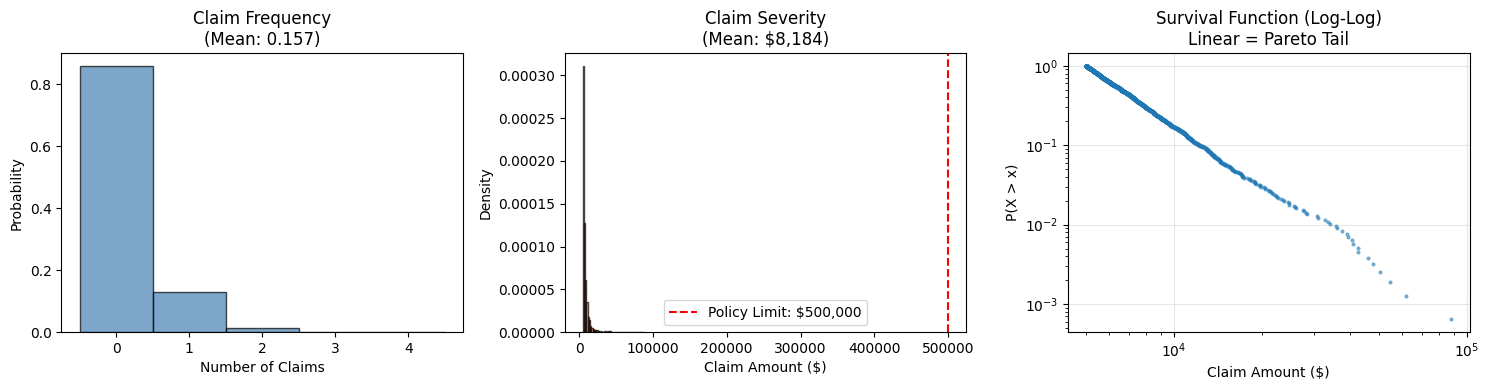

In [5]:
# Visualize the data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Claim frequency distribution
max_claims = min(10, claim_counts.max())
axes[0].hist(claim_counts, bins=range(max_claims + 2), density=True, alpha=0.7, 
             color='steelblue', edgecolor='black', align='left')
axes[0].set_xlabel('Number of Claims')
axes[0].set_ylabel('Probability')
axes[0].set_title(f'Claim Frequency\n(Mean: {claim_counts.mean():.3f})')
axes[0].set_xticks(range(max_claims + 1))

# Claim severity distribution (log scale)
axes[1].hist(claim_amounts, bins=50, density=True, alpha=0.7, 
             color='coral', edgecolor='black')
axes[1].set_xlabel('Claim Amount ($)')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Claim Severity\n(Mean: ${claim_amounts.mean():,.0f})')
axes[1].axvline(policy_limit, color='red', linestyle='--', label=f'Policy Limit: ${policy_limit:,}')
axes[1].legend()

# Log-log plot (Pareto tail)
sorted_claims = np.sort(claim_amounts)[::-1]
ranks = np.arange(1, len(sorted_claims) + 1)
survival_prob = ranks / len(sorted_claims)

axes[2].loglog(sorted_claims, survival_prob, 'o', markersize=2, alpha=0.5)
axes[2].set_xlabel('Claim Amount ($)')
axes[2].set_ylabel('P(X > x)')
axes[2].set_title('Survival Function (Log-Log)\nLinear = Pareto Tail')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Fit Claim Frequency Distribution

For claim counts, we'll compare:

- **Poisson**: Assumes variance = mean (rarely true in practice)
- **Negative Binomial**: Allows overdispersion (variance > mean)
- **Geometric**: Special case of NB with n=1

In [6]:
# Fit discrete distributions to claim counts
disc_fitter = DiscreteDistributionFitter(spark)

freq_results = disc_fitter.fit(
    policy_spark,
    column='num_claims'
)

print(f"Fitted {freq_results.count()} frequency distributions")

# Show top candidates
print("\nBest Frequency Distributions (by AIC):")
for fit in freq_results.best(n=5, metric='aic'):
    print(f"  {fit.distribution}: AIC={fit.aic:.1f}, BIC={fit.bic:.1f}")

Fitted 11 frequency distributions

Best Frequency Distributions (by AIC):
  nbinom: AIC=9143.2, BIC=9157.6
  betabinom: AIC=9145.8, BIC=9167.5
  poisson: AIC=9151.3, BIC=9158.5
  skellam: AIC=9153.3, BIC=9167.7
  binom: AIC=9164.1, BIC=9178.5


In [7]:
# Get best frequency fit (explicitly use AIC metric)
best_freq = freq_results.best(n=1, metric='aic')[0]

print(f"Best Frequency Model: {best_freq.distribution}")
print(f"  Parameters: {best_freq.parameters}")
print(f"  AIC: {best_freq.aic:.2f}")

# Compare with Poisson (often used but may not fit well)
poisson_fit = None
for fit in freq_results.best(n=10, metric='aic'):
    if fit.distribution == 'poisson':
        poisson_fit = fit
        break

if poisson_fit:
    print(f"\nPoisson Model (for comparison):")
    print(f"  Parameters: {poisson_fit.parameters}")
    print(f"  AIC: {poisson_fit.aic:.2f}")
    print(f"  AIC Difference: {poisson_fit.aic - best_freq.aic:.1f} (lower is better)")

Best Frequency Model: nbinom
  Parameters: [3.2799174785614014, 0.9544585943222046]
  AIC: 9143.19

Poisson Model (for comparison):
  Parameters: [0.15649999678134918]
  AIC: 9151.30
  AIC Difference: 8.1 (lower is better)


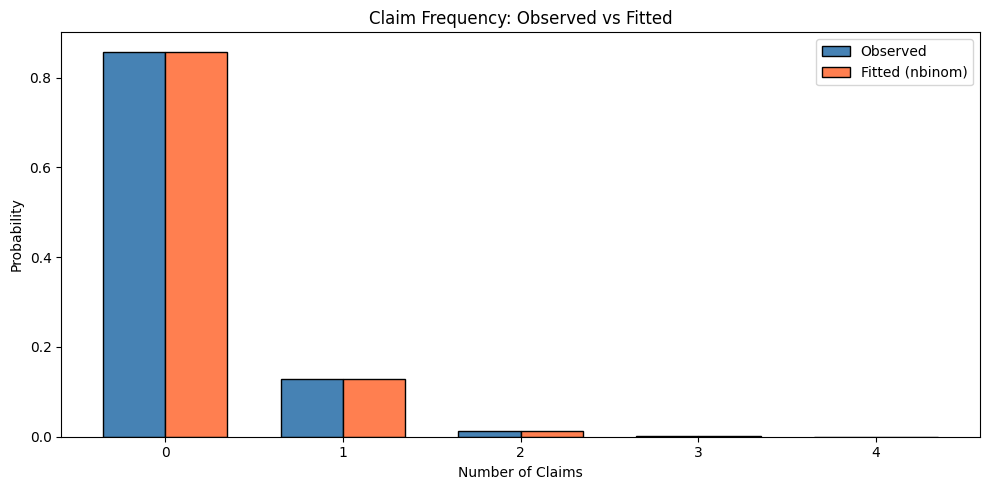

In [8]:
# Visualize frequency fit
fig, ax = plt.subplots(figsize=(10, 5))

# Observed frequencies
max_k = min(8, claim_counts.max())
observed_freq = np.array([np.sum(claim_counts == k) for k in range(max_k + 1)]) / n_policies

x = np.arange(max_k + 1)
width = 0.35

# Plot observed
bars1 = ax.bar(x - width/2, observed_freq, width, label='Observed', color='steelblue', edgecolor='black')

# Plot fitted (best model) - use get_scipy_dist() for frozen distribution
freq_dist = best_freq.get_scipy_dist()
# For discrete distributions, we need to handle the loc parameter
fitted_freq = freq_dist.pmf(x)
bars2 = ax.bar(x + width/2, fitted_freq, width, label=f'Fitted ({best_freq.distribution})', 
               color='coral', edgecolor='black')

ax.set_xlabel('Number of Claims')
ax.set_ylabel('Probability')
ax.set_title('Claim Frequency: Observed vs Fitted')
ax.set_xticks(x)
ax.legend()

plt.tight_layout()
plt.show()

## Part 3: Fit Claim Severity Distribution

For claim amounts, heavy-tailed distributions are essential:

- **Pareto**: Power-law tail, common for catastrophic losses
- **Lognormal**: Multiplicative processes, moderate tail
- **Gamma/Weibull**: Lighter tails, good for attritional losses

The choice matters enormously for extreme quantiles (99th percentile)!

In [9]:
# Fit severity distributions
cont_fitter = DistributionFitter(spark)

# Fit with limited distributions for speed
# Includes heavy-tailed options: pareto, lognorm, burr, gamma, weibull, etc.
severity_results = cont_fitter.fit(
    claims_spark,
    column='claim_amount',
    max_distributions=20,  # Includes heavy-tailed distributions
    lazy_metrics=True
)

print(f"Fitted {severity_results.count()} severity distributions")

# Show rankings
print("\nBest Severity Distributions (by AIC):")
for fit in severity_results.best(n=5, metric='aic'):
    print(f"  {fit.distribution}: AIC={fit.aic:.1f}")

Fitted 20 severity distributions

Best Severity Distributions (by AIC):
  exponweib: AIC=28118.9
  beta: AIC=28228.2
  erlang: AIC=28229.5
  alpha: AIC=28266.2
  chi2: AIC=28317.1


In [10]:
# Get best severity fit (explicitly use AIC metric)
best_severity = severity_results.best(n=1, metric='aic')[0]

print(f"Best Severity Model: {best_severity.distribution}")
print(f"  Parameters: {best_severity.parameters}")
print(f"  AIC: {best_severity.aic:.2f}")

Best Severity Model: exponweib
  Parameters: [1.331204891204834, 0.6737406849861145, 5001.7646484375, 1913.7969970703125]
  AIC: 28118.88


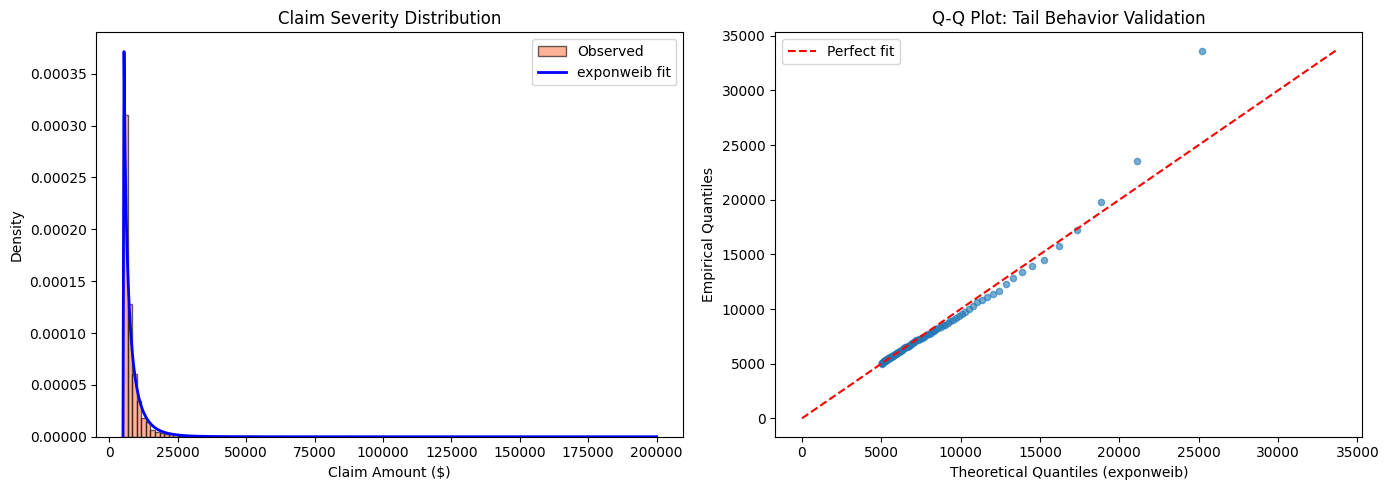

In [11]:
# Visualize severity fit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PDF comparison
x = np.linspace(5000, 200000, 500)

axes[0].hist(claim_amounts[claim_amounts < 200000], bins=50, density=True, 
             alpha=0.6, color='coral', edgecolor='black', label='Observed')

# Plot fitted PDF using get_scipy_dist()
severity_dist = best_severity.get_scipy_dist()
fitted_pdf = severity_dist.pdf(x)
axes[0].plot(x, fitted_pdf, 'b-', lw=2, label=f'{best_severity.distribution} fit')

axes[0].set_xlabel('Claim Amount ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Claim Severity Distribution')
axes[0].legend()

# Q-Q Plot for tail validation
theoretical_quantiles = severity_dist.ppf(np.linspace(0.01, 0.99, 100))
empirical_quantiles = np.percentile(claim_amounts, np.linspace(1, 99, 100))

axes[1].scatter(theoretical_quantiles, empirical_quantiles, alpha=0.6, s=20)
max_val = max(theoretical_quantiles.max(), empirical_quantiles.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', label='Perfect fit')
axes[1].set_xlabel(f'Theoretical Quantiles ({best_severity.distribution})')
axes[1].set_ylabel('Empirical Quantiles')
axes[1].set_title('Q-Q Plot: Tail Behavior Validation')
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 4: Bounded Fitting for Capped Claims

Our data has claims capped at the policy limit ($500K). For reserving purposes,
we might want to model the **unlimited** severity (what claims would have been
without the cap).

We'll fit to uncapped claims only, then extrapolate.

In [12]:
# Filter to uncapped claims for "ground-up" severity fitting
uncapped_claims = claim_amounts[claim_amounts < policy_limit]
uncapped_spark = spark.createDataFrame(pd.DataFrame({'claim_amount': uncapped_claims}))

print(f"Uncapped claims: {len(uncapped_claims):,} ({len(uncapped_claims)/len(claim_amounts):.1%} of total)")

# Fit to uncapped data with heavy-tailed distributions
uncapped_results = cont_fitter.fit(
    uncapped_spark,
    column='claim_amount',
    max_distributions=15,  # Includes pareto, lognorm, gamma, burr, etc.
    lazy_metrics=True
)

best_uncapped = uncapped_results.best(n=1, metric='aic')[0]
print(f"\nBest Uncapped Model: {best_uncapped.distribution}")
print(f"  Parameters: {best_uncapped.parameters}")

Uncapped claims: 1,565 (100.0% of total)



Best Uncapped Model: beta
  Parameters: [0.7411396503448486, 304.9739990234375, 5001.7646484375, 1287776.125]


In [13]:
# Compare expected unlimited loss vs limited loss
# Use get_scipy_dist() to get the frozen distribution
uncapped_dist = best_uncapped.get_scipy_dist()

# Expected unlimited claim (from fitted distribution)
expected_unlimited = uncapped_dist.mean()

# Expected limited claim (truncated at policy limit)
# E[min(X, L)] = integral from 0 to L of S(x) dx where S(x) = 1 - F(x)
from scipy.integrate import quad

def survival(x):
    return 1 - uncapped_dist.cdf(x)

expected_limited, _ = quad(survival, 0, policy_limit)

print(f"Expected Claim Amounts:")
print(f"  Unlimited (model): ${expected_unlimited:,.0f}")
print(f"  Limited at ${policy_limit:,}: ${expected_limited:,.0f}")
print(f"  Observed mean: ${claim_amounts.mean():,.0f}")
print(f"\n  Loss due to limit: ${expected_unlimited - expected_limited:,.0f} per claim ({(expected_unlimited - expected_limited)/expected_unlimited:.1%})")

Expected Claim Amounts:
  Unlimited (model): $8,124
  Limited at $500,000: $8,124
  Observed mean: $8,184

  Loss due to limit: $0 per claim (0.0%)


## Part 5: Aggregate Loss Distribution

The aggregate loss $S = \sum_{i=1}^N X_i$ combines frequency and severity.
We'll use Monte Carlo simulation with our fitted distributions.

In [14]:
def simulate_aggregate_loss(freq_fit, sev_fit, n_policies, policy_limit, n_simulations=10000, seed=42):
    """
    Simulate aggregate loss distribution using fitted frequency and severity.
    
    Returns array of simulated annual aggregate losses.
    """
    np.random.seed(seed)
    
    # Get frozen scipy distributions using get_scipy_dist()
    freq_dist = freq_fit.get_scipy_dist()
    sev_dist = sev_fit.get_scipy_dist()
    
    aggregate_losses = []
    
    for _ in range(n_simulations):
        # Simulate claim counts for all policies
        counts = freq_dist.rvs(size=n_policies)
        # Ensure non-negative integer counts
        counts = np.maximum(0, np.round(counts)).astype(int)
        total_claims = counts.sum()
        
        if total_claims > 0:
            # Simulate claim amounts
            amounts = sev_dist.rvs(size=total_claims)
            # Apply policy limit
            amounts = np.minimum(amounts, policy_limit)
            aggregate_loss = amounts.sum()
        else:
            aggregate_loss = 0
        
        aggregate_losses.append(aggregate_loss)
    
    return np.array(aggregate_losses)

# Run simulation
print("Simulating aggregate losses...")
aggregate_losses = simulate_aggregate_loss(
    best_freq, 
    best_severity,  
    n_policies=n_policies,
    policy_limit=policy_limit,
    n_simulations=10000
)

print(f"\nAggregate Loss Distribution (Annual):")
print(f"  Mean: ${aggregate_losses.mean():,.0f}")
print(f"  Std Dev: ${aggregate_losses.std():,.0f}")
print(f"  Median: ${np.median(aggregate_losses):,.0f}")
print(f"  Observed (actual): ${claim_amounts.sum():,.0f}")

Simulating aggregate losses...



Aggregate Loss Distribution (Annual):
  Mean: $12,698,881
  Std Dev: $365,736
  Median: $12,690,702
  Observed (actual): $12,807,652


In [15]:
# Calculate risk metrics
var_95 = np.percentile(aggregate_losses, 95)
var_99 = np.percentile(aggregate_losses, 99)
var_995 = np.percentile(aggregate_losses, 99.5)

# TVaR (Expected Shortfall)
tvar_95 = aggregate_losses[aggregate_losses >= var_95].mean()
tvar_99 = aggregate_losses[aggregate_losses >= var_99].mean()

print("Risk Metrics:")
print(f"\n  Value-at-Risk (VaR):")
print(f"    95%: ${var_95:,.0f}")
print(f"    99%: ${var_99:,.0f}")
print(f"    99.5%: ${var_995:,.0f}")

print(f"\n  Tail Value-at-Risk (TVaR/ES):")
print(f"    95%: ${tvar_95:,.0f}")
print(f"    99%: ${tvar_99:,.0f}")

Risk Metrics:

  Value-at-Risk (VaR):
    95%: $13,310,286
    99%: $13,555,970
    99.5%: $13,647,915

  Tail Value-at-Risk (TVaR/ES):
    95%: $13,460,696
    99%: $13,677,761


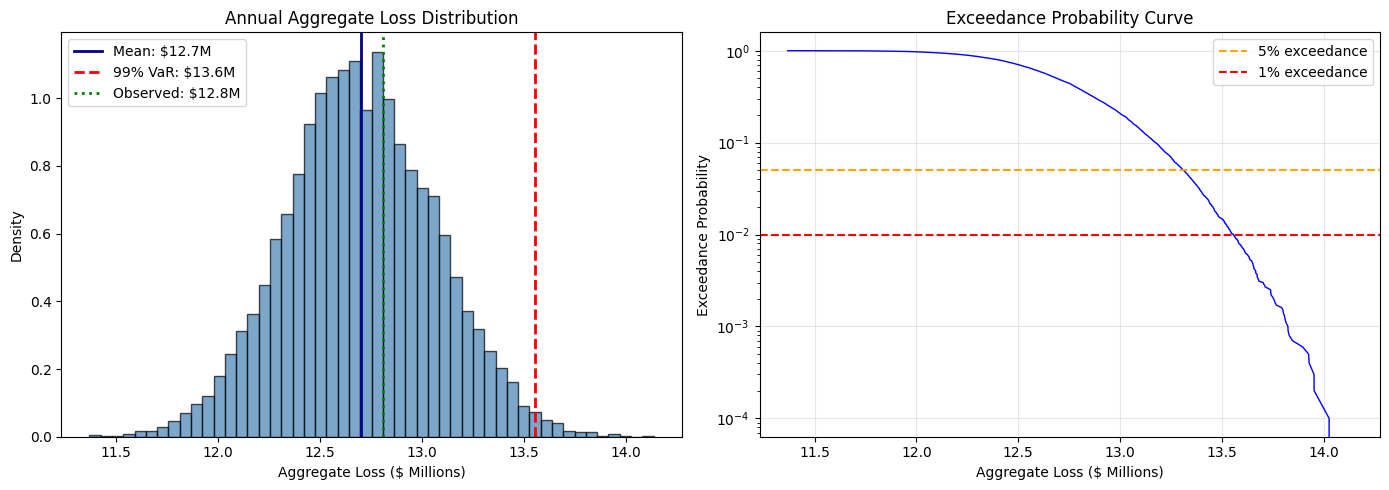

In [16]:
# Visualize aggregate loss distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(aggregate_losses / 1e6, bins=50, density=True, alpha=0.7, 
             color='steelblue', edgecolor='black')
axes[0].axvline(aggregate_losses.mean() / 1e6, color='darkblue', linestyle='-', 
                lw=2, label=f'Mean: ${aggregate_losses.mean()/1e6:.1f}M')
axes[0].axvline(var_99 / 1e6, color='red', linestyle='--', 
                lw=2, label=f'99% VaR: ${var_99/1e6:.1f}M')
axes[0].axvline(claim_amounts.sum() / 1e6, color='green', linestyle=':', 
                lw=2, label=f'Observed: ${claim_amounts.sum()/1e6:.1f}M')
axes[0].set_xlabel('Aggregate Loss ($ Millions)')
axes[0].set_ylabel('Density')
axes[0].set_title('Annual Aggregate Loss Distribution')
axes[0].legend()

# Exceedance probability curve
sorted_losses = np.sort(aggregate_losses)
exceedance_prob = 1 - np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)

axes[1].semilogy(sorted_losses / 1e6, exceedance_prob, 'b-', lw=1)
axes[1].axhline(0.05, color='orange', linestyle='--', label='5% exceedance')
axes[1].axhline(0.01, color='red', linestyle='--', label='1% exceedance')
axes[1].set_xlabel('Aggregate Loss ($ Millions)')
axes[1].set_ylabel('Exceedance Probability')
axes[1].set_title('Exceedance Probability Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 6: Premium Calculation

Use the fitted distributions to calculate risk-based premiums.

In [17]:
# Premium calculation
expected_loss = aggregate_losses.mean()
loss_std = aggregate_losses.std()

# Loading factors
expense_loading = 0.25      # 25% for expenses
profit_loading = 0.05       # 5% target profit
risk_loading_factor = 0.10  # Risk load = 10% of std dev

# Technical premium
pure_premium = expected_loss
risk_load = risk_loading_factor * loss_std
technical_premium = pure_premium + risk_load

# Gross premium
gross_premium = technical_premium / (1 - expense_loading - profit_loading)

# Per-policy premium
per_policy = gross_premium / n_policies

print("Premium Calculation (Annual Portfolio):")
print(f"\n  Expected Loss (Pure Premium): ${expected_loss:,.0f}")
print(f"  Risk Loading (10% × σ): ${risk_load:,.0f}")
print(f"  Technical Premium: ${technical_premium:,.0f}")
print(f"\n  Expense Loading (25%): ${gross_premium * expense_loading:,.0f}")
print(f"  Profit Loading (5%): ${gross_premium * profit_loading:,.0f}")
print(f"\n  Gross Premium: ${gross_premium:,.0f}")
print(f"  Per Policy: ${per_policy:,.0f}")

# Loss ratio analysis
print(f"\n  Expected Loss Ratio: {expected_loss / gross_premium:.1%}")
print(f"  99% VaR Loss Ratio: {var_99 / gross_premium:.1%}")

Premium Calculation (Annual Portfolio):

  Expected Loss (Pure Premium): $12,698,881
  Risk Loading (10% × σ): $36,574
  Technical Premium: $12,735,454

  Expense Loading (25%): $4,548,376
  Profit Loading (5%): $909,675

  Gross Premium: $18,193,506
  Per Policy: $1,819

  Expected Loss Ratio: 69.8%
  99% VaR Loss Ratio: 74.5%


## Summary

This notebook demonstrated actuarial modeling with spark-bestfit:

1. **Claim frequency modeling** with discrete distributions (Negative Binomial captures overdispersion)
2. **Claim severity modeling** with heavy-tailed distributions (Pareto, Burr)
3. **Q-Q plots** for validating tail behavior - critical for extreme loss estimation
4. **Bounded fitting** for policy limits and censored data
5. **Aggregate loss simulation** combining frequency and severity
6. **Risk metrics** (VaR, TVaR) for capital and reserving

### Key spark-bestfit Features Used

| Feature | Purpose |
|---------|----------|
| `DiscreteDistributionFitter` | Claim frequency (Poisson, NB) |
| Heavy-tail distributions | Claim severity (Pareto, Burr) |
| `lazy_metrics=True` | Fast model selection |
| `results.best(n=5)` | Compare distribution candidates |

### Actuarial Extensions

- **Credibility weighting**: Blend with prior for small portfolios
- **Covariate modeling**: GLM for frequency/severity by risk factors
- **Reinsurance pricing**: Layer excess-of-loss with fitted severity
- **IBNR reserves**: Project development patterns

In [18]:
# Cleanup
spark.stop()